In [3]:
import alpaca_backtrader_api
import backtrader as bt
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [4]:
ALPACA_API_KEY ="PK8SSSXD3FX164IYREJ5"
ALPACA_SECRET_KEY ="NPKEgtQyt3fsRodbOqn4d46V19XI5W9S8Cv64dDT"
ALPACA_PAPER = True

In [5]:
from alpaca_trade_api.rest import REST, TimeFrame
api = REST(ALPACA_API_KEY,
           ALPACA_SECRET_KEY,
           'https://paper-api.alpaca.amrkets'
          )


In [6]:
# obtain 2-year data from a specific stock
symbol = 'SPY'
bar = api.get_barset(symbol, 'day', limit=730)

c = []
t = []
idx = []

for i in range(len(bar[symbol])):
    temp_c = c.append(bar[symbol][i].c) 
    temp_t = t.append(bar[symbol][i].t)
    temp_idx = idx.append(i)
    i = i + 1

df_bar_t = pd.DataFrame(t, idx,columns = ['Datetime'])
df_bar_c = pd.DataFrame(c, idx, columns = ['Close'])

new_data = pd.merge(df_bar_t,df_bar_c, left_index = True, right_index = True)
new_data

,Datetime,Close
0,2019-01-14 00:00:00-05:00,257.69
1,2019-01-15 00:00:00-05:00,260.21
2,2019-01-16 00:00:00-05:00,260.94
3,2019-01-17 00:00:00-05:00,262.88
4,2019-01-18 00:00:00-05:00,266.16
...,...,...
725,2021-11-29 00:00:00-05:00,464.63
726,2021-11-30 00:00:00-05:00,455.78
727,2021-12-01 00:00:00-05:00,450.53
728,2021-12-02 00:00:00-05:00,457.38


In [7]:
def add_nextdate(data):
    date=data.iloc[-1][0]
    price_fake= data.iloc[-1][1]
    date_n=date+timedelta(days=1)
    data.loc[len(data.index)]=[date_n,price_fake]
    print(data)
add_nextdate(new_data)

                     Datetime   Close
0   2019-01-14 00:00:00-05:00  257.69
1   2019-01-15 00:00:00-05:00  260.21
2   2019-01-16 00:00:00-05:00  260.94
3   2019-01-17 00:00:00-05:00  262.88
4   2019-01-18 00:00:00-05:00  266.16
..                        ...     ...
726 2021-11-30 00:00:00-05:00  455.78
727 2021-12-01 00:00:00-05:00  450.53
728 2021-12-02 00:00:00-05:00  457.38
729 2021-12-03 00:00:00-05:00  453.43
730 2021-12-04 00:00:00-05:00  453.43

[731 rows x 2 columns]


In [8]:
#creating dataframe
symbol = 'SPY'
bar = api.get_barset(symbol, 'day', limit=730)

c = []
t = []
idx = []

for i in range(len(bar[symbol])):
    temp_c = c.append(bar[symbol][i].c) 
    temp_t = t.append(bar[symbol][i].t)
    temp_idx = idx.append(i)
    i = i + 1

df_bar_t = pd.DataFrame(t, idx,columns = ['Date'])
df_bar_c = pd.DataFrame(c, idx, columns = ['Close'])

new_data = pd.merge(df_bar_t,df_bar_c, left_index = True, right_index = True)
add_nextdate(new_data)
 
#change index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
 
#creating train and test sets
dataset = new_data.values
 
train = dataset[0:511,:]
valid = dataset[511:,:]
 
#converting dataset into X_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

#--------------------------
# training model 
X_train, y_train = [], []
for i in range(60,len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
 
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
 
# add LSTM network
model = Sequential([
    layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)), 
    layers.Dropout(0.2),
    layers.LSTM(units = 50),
    layers.Dropout(0.2),
    # layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    # layers.Dropout(0.2),
    layers.Dense(units = 1)
    ])
 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=2)

 
#using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
 
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

                         Date   Close
0   2019-01-14 00:00:00-05:00  257.69
1   2019-01-15 00:00:00-05:00  260.21
2   2019-01-16 00:00:00-05:00  260.94
3   2019-01-17 00:00:00-05:00  262.88
4   2019-01-18 00:00:00-05:00  266.16
..                        ...     ...
726 2021-11-30 00:00:00-05:00  455.78
727 2021-12-01 00:00:00-05:00  450.53
728 2021-12-02 00:00:00-05:00  457.38
729 2021-12-03 00:00:00-05:00  453.43
730 2021-12-04 00:00:00-05:00  453.43

[731 rows x 2 columns]


2021-12-03 13:12:28.945281: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
15/15 - 8s - loss: 0.0429 - 8s/epoch - 519ms/step
Epoch 2/15
15/15 - 1s - loss: 0.0070 - 667ms/epoch - 44ms/step
Epoch 3/15
15/15 - 1s - loss: 0.0051 - 648ms/epoch - 43ms/step
Epoch 4/15
15/15 - 1s - loss: 0.0041 - 622ms/epoch - 41ms/step
Epoch 5/15
15/15 - 1s - loss: 0.0034 - 920ms/epoch - 61ms/step
Epoch 6/15
15/15 - 1s - loss: 0.0032 - 984ms/epoch - 66ms/step
Epoch 7/15
15/15 - 1s - loss: 0.0033 - 949ms/epoch - 63ms/step
Epoch 8/15
15/15 - 1s - loss: 0.0037 - 643ms/epoch - 43ms/step
Epoch 9/15
15/15 - 1s - loss: 0.0040 - 962ms/epoch - 64ms/step
Epoch 10/15
15/15 - 1s - loss: 0.0035 - 696ms/epoch - 46ms/step
Epoch 11/15
15/15 - 1s - loss: 0.0026 - 615ms/epoch - 41ms/step
Epoch 12/15
15/15 - 1s - loss: 0.0027 - 622ms/epoch - 41ms/step
Epoch 13/15
15/15 - 1s - loss: 0.0025 - 1s/epoch - 78ms/step
Epoch 14/15
15/15 - 1s - loss: 0.0026 - 820ms/epoch - 55ms/step
Epoch 15/15
15/15 - 1s - loss: 0.0024 - 1s/epoch - 81ms/step


In [9]:
# error calculation 
rms = np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

6.764239550033687

/var/folders/63/s_dlyjvx16z1cy0sqjdr_z840000gn/T/ipykernel_1929/2553808649.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


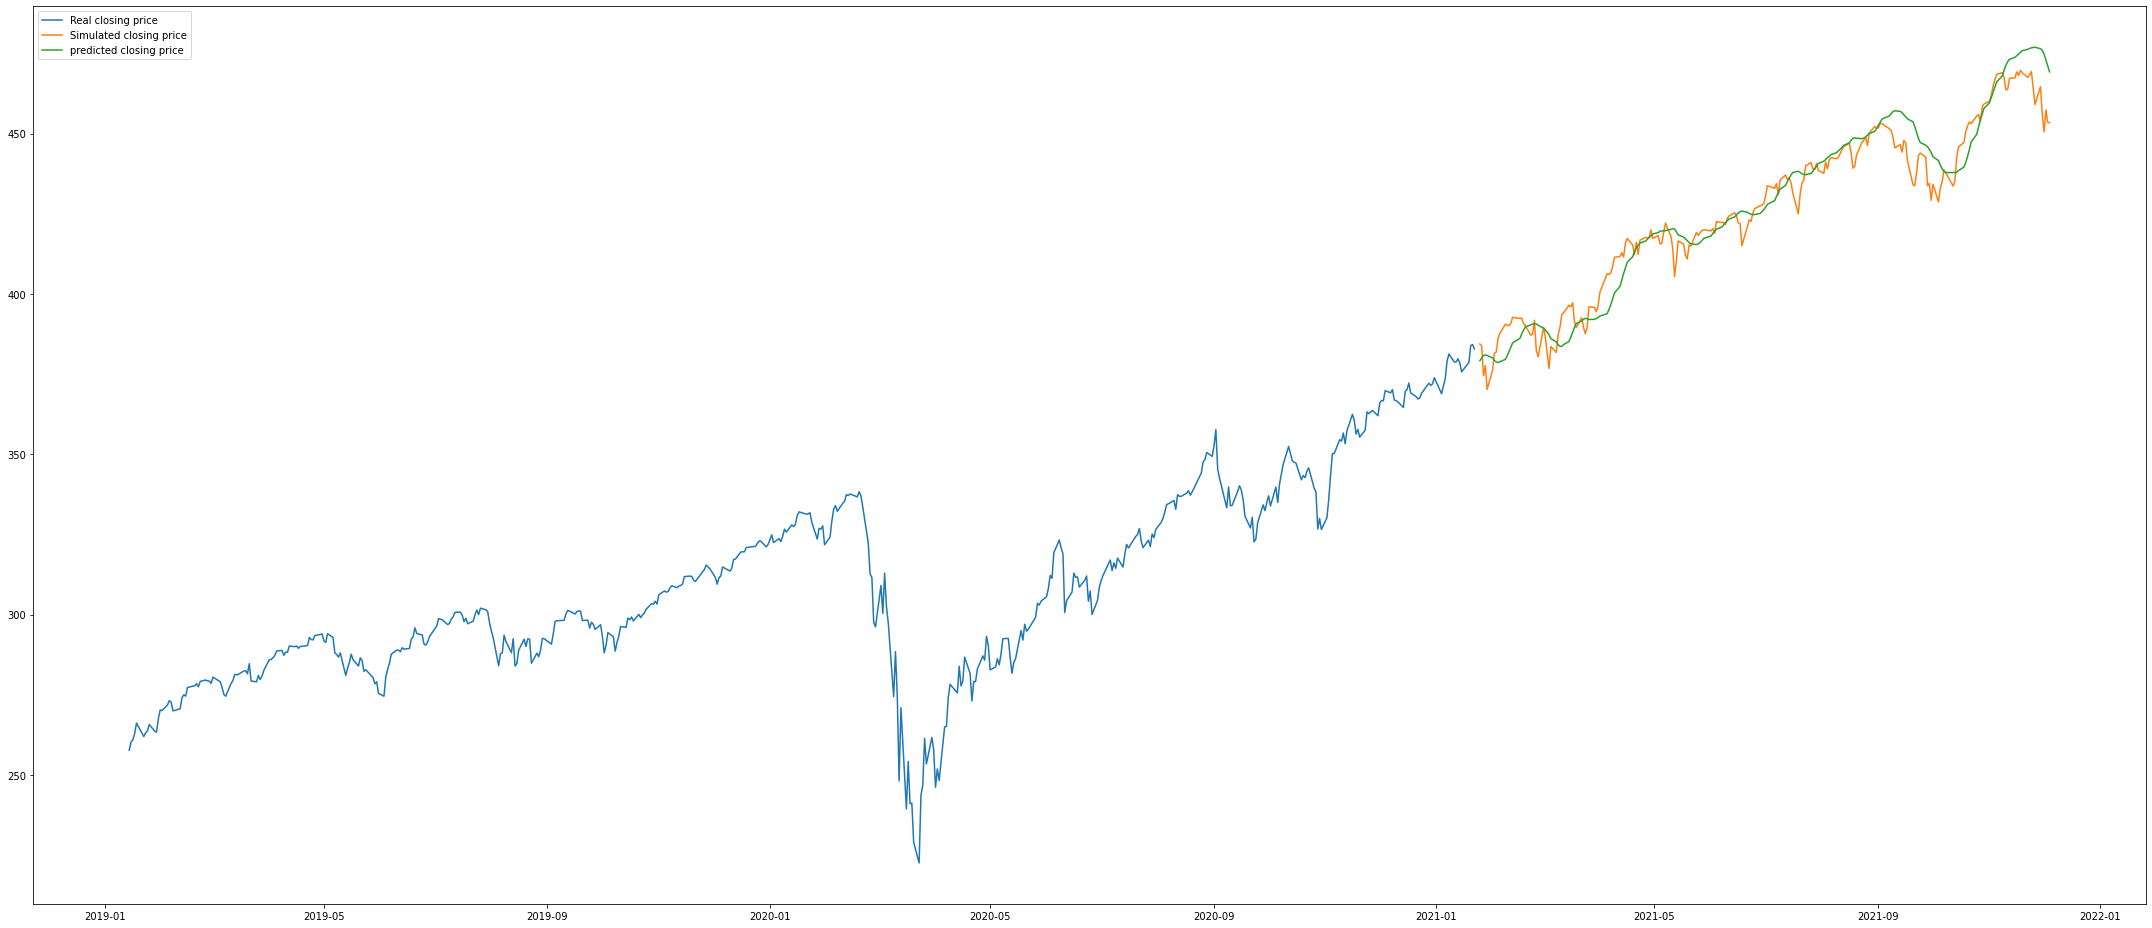

In [18]:
train = new_data[:511]
valid = new_data[511:]
valid['Predictions'] = closing_price
plt.rcParams["figure.figsize"] = [30, 13]
plt.rcParams["figure.autolayout"] = True
plt.plot(train['Close'], label = "Real closing price")
plt.plot(valid[['Close']], label = "Simulated closing price")
plt.plot(valid[['Predictions']], label = "predicted closing price")
plt.legend()

In [12]:
# predict how the closing price changes tomorrow
def nextday_predict(data):
    change = data.iloc[-1][0]-data.iloc[-1][1]
    return f"Tomorrow's closing price has changed by {change} compared with today"

change = nextday_predict(valid)
print(change)

Tomorrow's closing price has changed by -15.808647460937493 compared with today
